# Comparison of operators with code from Nick's paper review

In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pylops

from scipy.sparse.linalg import lobpcg as sp_lobpcg
from pylops import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.blending  import *

import cupy as cp
cp.cuda.Device(device=0).use();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Blending

In [21]:
## Compare with code from Nick's paper review
class SubshiftBlend:

    def __init__(self, n_channels, n_shots, n_times, shottimes):
        self.shottimes = (shottimes - min(shottimes).item()).astype(int)
        self.n_times = n_times
        n_blended_times = max(self.shottimes).item() + n_times
        self.deblended_shape = (n_channels, n_shots, n_times)
        self.blended_shape = (n_channels, n_blended_times)
        subshift = shottimes - shottimes.astype(int)
        self.fwd_shift = np.exp(-1j * 2 * np.pi * subshift.reshape(1, -1, 1) *
                                np.fft.rfftfreq(n_times + 1).reshape(1, 1, -1))
        self.adj_shift = np.conj(self.fwd_shift)

    def __call__(self, x):
        y = np.zeros(self.blended_shape, dtype=x.dtype)
        x = np.pad(x, ((0, 0), (0, 0), (0, 1)))
        x = np.fft.irfft(self.fwd_shift * np.fft.rfft(x),#.astype(np.complex64),
                         n=self.n_times + 1).astype(x.dtype)
        x = x[..., :-1]
        for channel_idx, channel in enumerate(x):
            for shot_idx, st in enumerate(self.shottimes):
                y[channel_idx, st:st + self.n_times] += channel[shot_idx]
        return y
    
    def adjoint(self, y):
        x = np.zeros(self.deblended_shape, dtype=y.dtype)
        for channel_idx, channel in enumerate(y):
            for shot_idx, st in enumerate(self.shottimes):
                x[channel_idx, shot_idx] = channel[st:st + self.n_times]
        x = np.pad(x, ((0, 0), (0, 0), (0, 1)))
        x = np.fft.irfft(self.adj_shift * np.fft.rfft(x),#.astype(np.complex64),
                         n=self.n_times + 1).astype(x.dtype)
        return x[..., :-1]

In [22]:
import numpy as np

from pylops import LinearOperator
from pylops.basicoperators import BlockDiag, HStack, Pad
from pylops.signalprocessing import Shift
from pylops.utils.backend import get_array_module
from pylops.utils.decorators import reshaped
from pylops.utils.typing import DTypeLike, NDArray


class BlendingContinuousFast(LinearOperator):
    """copying the one above into a pylops operator (to see if there is any overhead)"""
    def __init__(
        self,
        nt: int,
        nr: int,
        ns: int,
        dt: float,
        times: NDArray,
        dtype: DTypeLike = "float64",
        name: str = "B",
    ) -> None:
        self.dtype = np.dtype(dtype)
        
        self.shottimes = (times - min(times).item()).astype(int)
        self.n_times = nt
        n_blended_times = max(self.shottimes).item() + nt
        self.deblended_shape = (nr, ns, nt)
        self.blended_shape = (nr, n_blended_times)
        subshift = times - times.astype(int)
        self.fwd_shift = np.exp(-1j * 2 * np.pi * subshift.reshape(1, -1, 1) *
                                np.fft.rfftfreq(nt + 1).reshape(1, 1, -1))
        self.adj_shift = np.conj(self.fwd_shift)

        super().__init__(
            dtype=np.dtype(dtype),
            dims=self.deblended_shape,
            dimsd=self.blended_shape,
            name=name,
        )

    @reshaped
    def _matvec(self, x: NDArray) -> NDArray:
        y = np.zeros(self.blended_shape, dtype=x.dtype)
        x = np.pad(x, ((0, 0), (0, 0), (0, 1)))
        x = np.fft.irfft(self.fwd_shift * np.fft.rfft(x),#.astype(np.complex64),
                         n=self.n_times + 1).astype(x.dtype)
        x = x[..., :-1]
        for channel_idx, channel in enumerate(x):
            for shot_idx, st in enumerate(self.shottimes):
                y[channel_idx, st:st + self.n_times] += channel[shot_idx]
        return y
    
    @reshaped
    def _rmatvec(self, y: NDArray) -> NDArray:
        x = np.zeros(self.deblended_shape, dtype=y.dtype)
        for channel_idx, channel in enumerate(y):
            for shot_idx, st in enumerate(self.shottimes):
                x[channel_idx, shot_idx] = channel[st:st + self.n_times]
        x = np.pad(x, ((0, 0), (0, 0), (0, 1)))
        x = np.fft.irfft(self.adj_shift * np.fft.rfft(x),#.astype(np.complex64),
                         n=self.n_times + 1).astype(x.dtype)
        return x[..., :-1]

Load the data

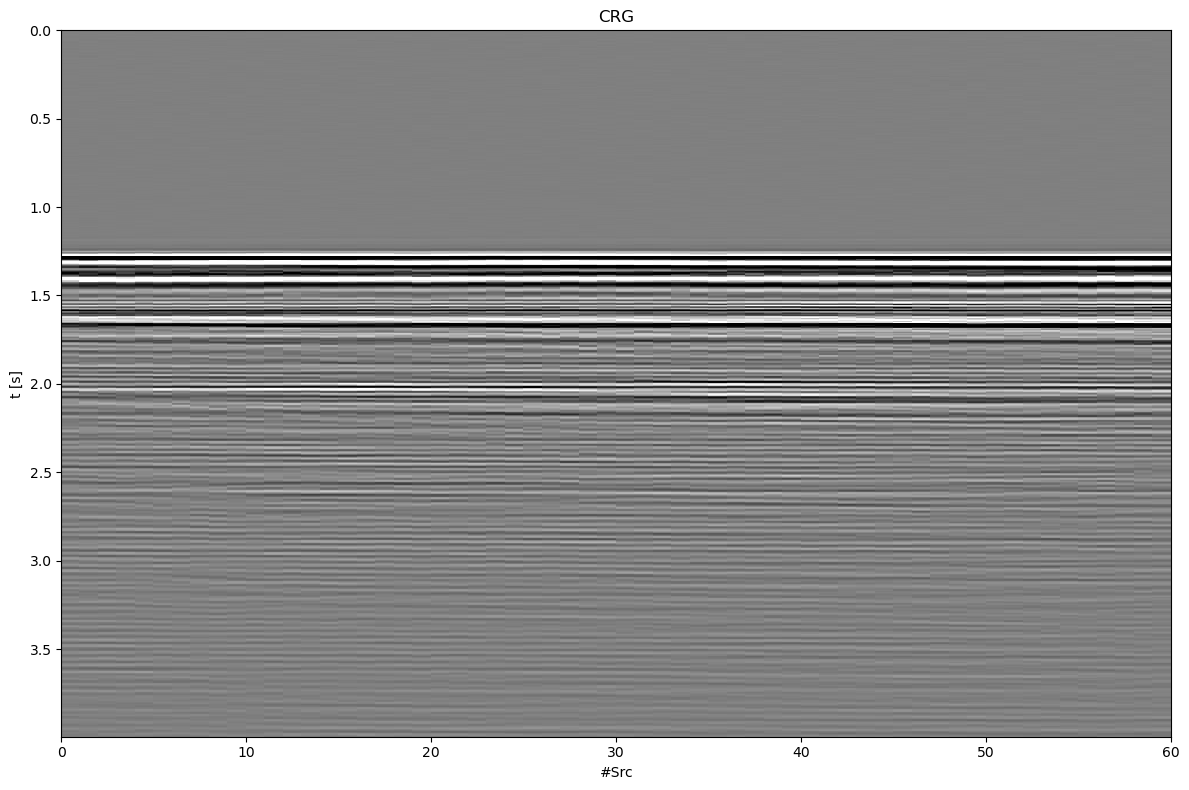

In [23]:
data = np.load("../../pylops/testdata/deblending/mobil.npy")
ns, nt = data.shape

dt = 0.004
t = np.arange(nt) * dt

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data.T,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.set_title("CRG")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout();

### Continuous blending small dataset (2d example with multiple receivers)

In [24]:
# Add fake receivers
nr = 10 # min 4 
data1 = np.repeat(data[:, np.newaxis, :], nr, axis=1)
data1[:, 1] *= -1
data1[:, 3] *= -1
print(data1.shape)

# Firing times
overlap = 0.5
ignition_times = 2.0 * np.random.rand(ns) - 1.0
ignition_times1 = np.arange(0, overlap * nt * ns, overlap * nt) * dt + ignition_times
ignition_times1[0] = 0.

(60, 10, 1000)


In [25]:
Bop = BlendingContinuous(nt, nr, ns, dt, ignition_times1, shiftall=True if nr < 20 else True, dtype="float64")
#Bop = BlendingContinuousFast(nt, nr, ns, dt, ignition_times1, dtype="float64")
Bop1 = SubshiftBlend(nr, ns, nt, ignition_times1/dt)

Bopcp = BlendingContinuous(nt, nr, ns, dt, ignition_times1.astype("float32"), shiftall=True if nr < 20 else True, dtype="float32")

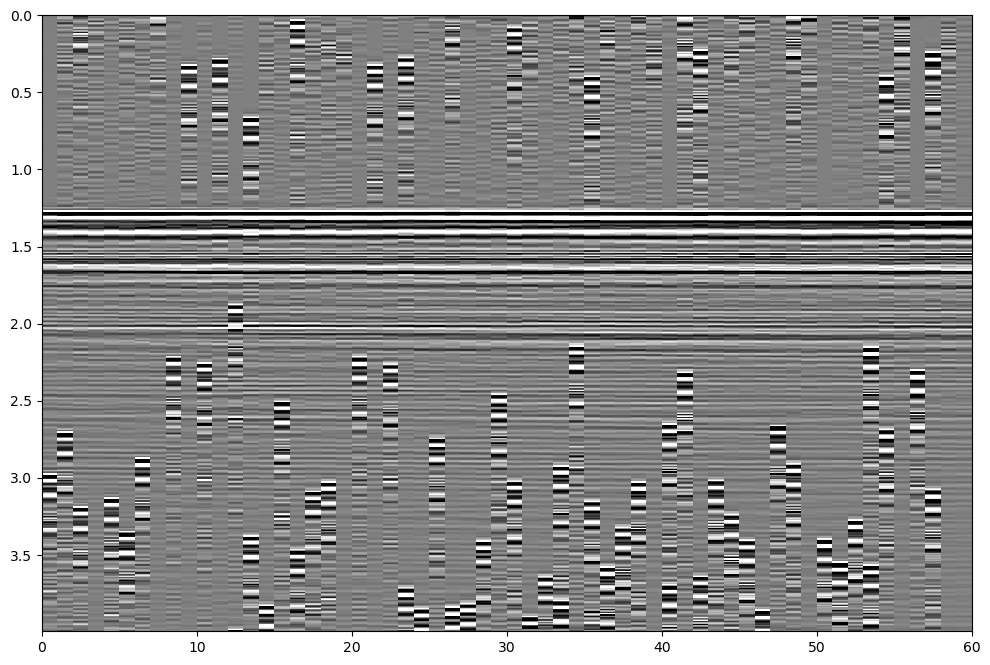

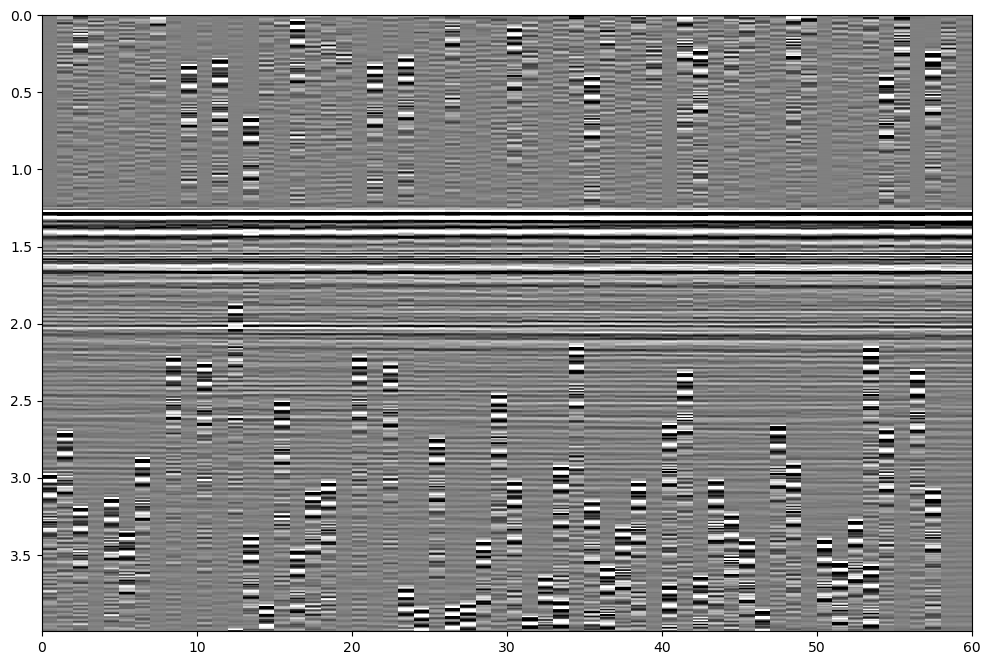

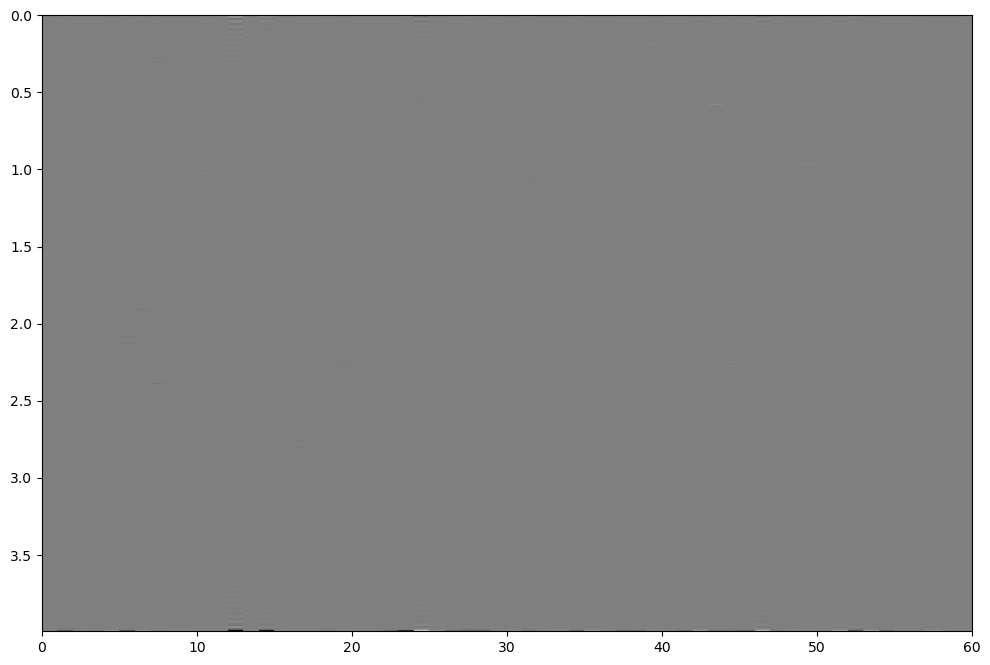

In [26]:
data_blended = Bop * data1
data_pseudo = Bop.H * data_blended

data_blended1 = Bop1(data1.transpose(1, 0, 2))
data_pseudo1 = Bop1.adjoint(data_blended1).transpose(1, 0, 2)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo[:, 0].squeeze().T,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.axis("tight")

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo1[:, 0].squeeze().T,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.axis("tight")

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo[:, 0].squeeze().T - data_pseudo1[:, 0].squeeze().T,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.axis("tight");

In [27]:
data_blended_cp = Bopcp.matvec(cp.asarray(data1.ravel().astype("float32")))
data_pseudo_cp = Bopcp.rmatvec(data_blended_cp.astype("float32"))

print(type(data_blended_cp), data_blended_cp.dtype, type(data_pseudo_cp), data_pseudo_cp.dtype)

<class 'cupy.ndarray'> float32 <class 'cupy.ndarray'> float32


In [28]:
%timeit -n 2 -r 2 Bop.matvec(data1.ravel())
%timeit -n 2 -r 2 Bop1(data1.transpose(1, 0, 2))
%timeit -n 2 -r 2 Bopcp * cp.asarray(data1.astype("float32"))

%timeit -n 2 -r 2 Bop.rmatvec(data_blended.ravel())
%timeit -n 2 -r 2 Bop1.adjoint(data_blended).transpose(1, 0, 2)
%timeit -n 2 -r 2 Bopcp.rmatvec(data_blended_cp.astype("float32"))

17.6 ms ± 1.39 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
12 ms ± 329 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
2.44 ms ± 217 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
16.3 ms ± 712 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
11.9 ms ± 41.8 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
1.86 ms ± 181 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)


### Continuous blending single receiver and multiple shots (mimic 3d)

In [29]:
# Add fake sources
nsother = 200
data3d = np.repeat(data[:, np.newaxis, :], nsother, axis=1)
print(data3d.shape)

data3d = data3d.reshape(ns*nsother, 1, nt)
print(data3d.shape)

# Firing times
overlap = 0.5
ignition_times = 2.0 * np.random.rand(ns*nsother) - 1.0
ignition_times1 = np.arange(0, overlap * nt * ns * nsother, overlap * nt) * dt + ignition_times
ignition_times1[0] = 0.

(60, 200, 1000)
(12000, 1, 1000)


In [30]:
Bop = BlendingContinuous(nt, 1, ns*nsother, dt, ignition_times1, shiftall=True, dtype="float64")
Bop1 = SubshiftBlend(1, ns*nsother, nt, ignition_times1/dt)

Bopcp = BlendingContinuous(nt, 1, ns*nsother, dt, ignition_times1.astype("float32"), shiftall=True, dtype="float32")

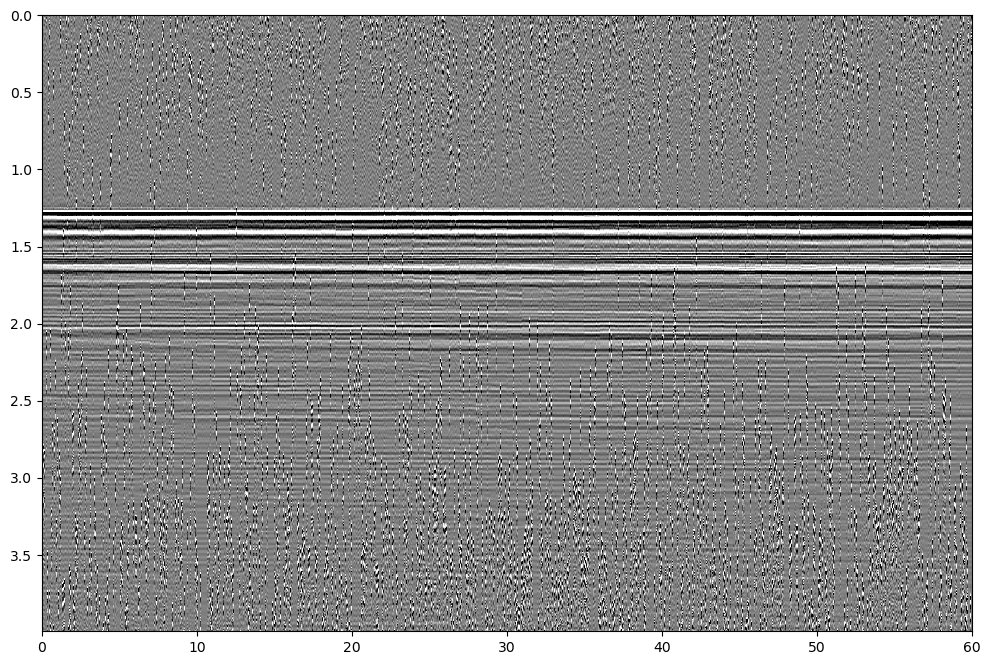

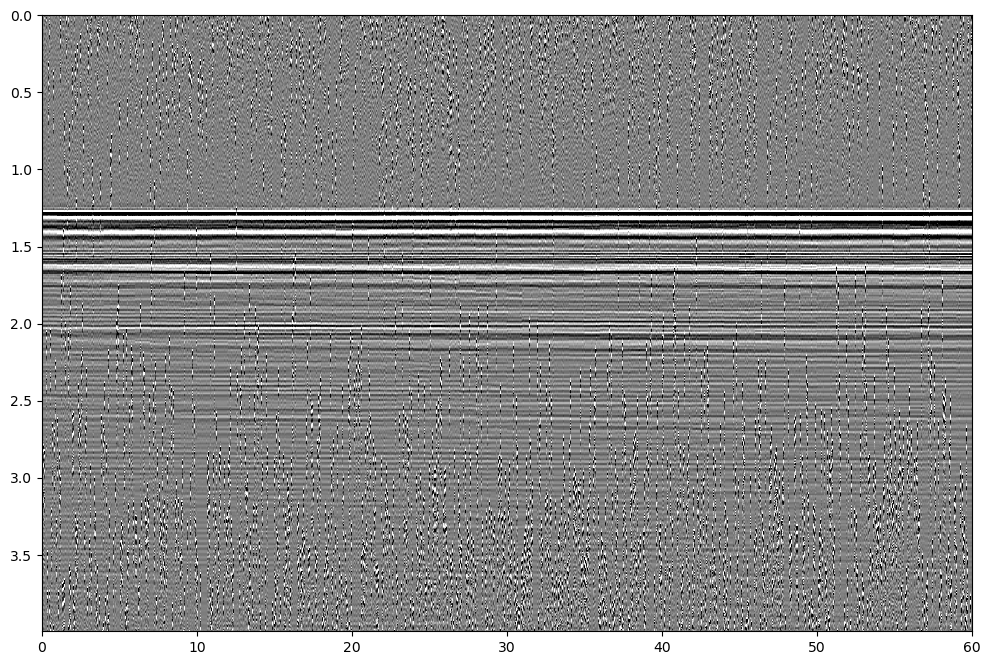

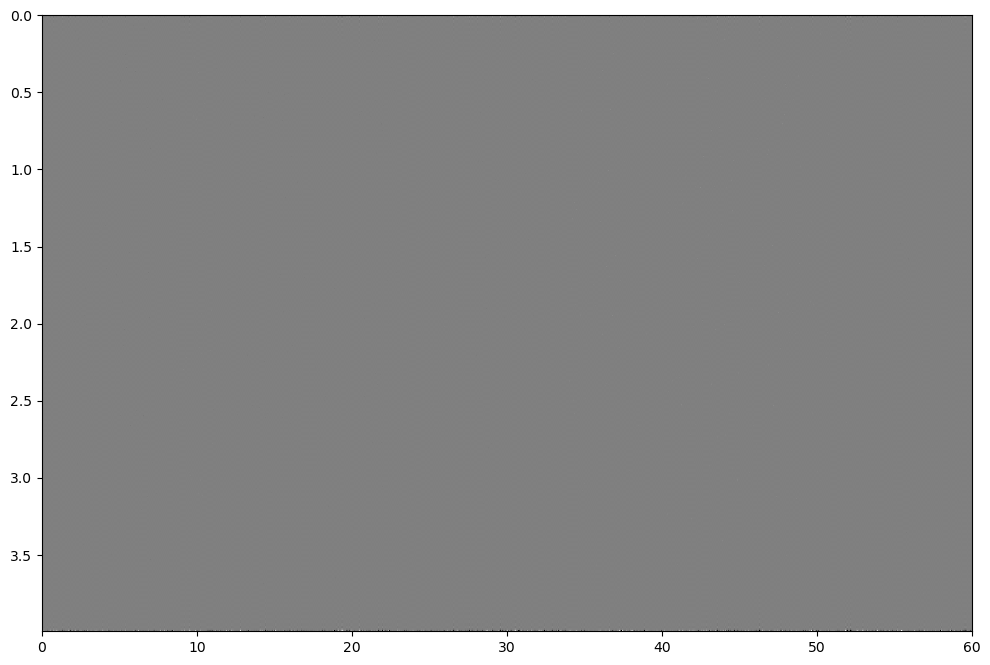

In [31]:
data_blended = Bop * data3d
data_pseudo = Bop.H * data_blended

data_blended1 = Bop1(data3d.transpose(1, 0, 2))
data_pseudo1 = Bop1.adjoint(data_blended1)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo.squeeze().T,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.axis("tight")

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo1.squeeze().T,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.axis("tight")

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo.squeeze().T-data_pseudo1.squeeze().T,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.axis("tight");

In [32]:
data3d_cp = cp.asarray(data3d.ravel().astype("float32"))

data_blended_cp = Bopcp.matvec(data3d_cp)
data_pseudo_cp = Bopcp.rmatvec(data_blended_cp)

print(type(data_blended_cp), data_blended_cp.dtype, type(data_pseudo_cp), data_pseudo_cp.dtype)

<class 'cupy.ndarray'> float32 <class 'cupy.ndarray'> float32


In [33]:
%timeit -n 2 -r 2 Bop * data3d
%timeit -n 2 -r 2 Bop1(data3d.transpose(1, 0, 2))
%timeit -n 2 -r 2 Bopcp.matvec(cp.asarray(data3d_cp))

%timeit -n 2 -r 2 Bop.H * data_blended
%timeit -n 2 -r 2 Bop1.adjoint(data_blended1).transpose(1, 0, 2)
%timeit -n 2 -r 2 Bopcp.rmatvec(data_blended_cp)

611 ms ± 3.57 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
382 ms ± 2.41 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
551 ms ± 1.11 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
714 ms ± 1.84 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
385 ms ± 1.43 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
225 ms ± 862 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)


#### Conclusions

For a single receiver, their method seems faster than ours **(even when we go to gpu the forward is slow...)**

### Continuous blending multiple receivers and multiple shots (many as to mimic 3d)

In [34]:
# Add fake sources and fake recs
nsother = 20
nrother = 40

data3d = np.repeat(data[:, np.newaxis, :], nsother*nrother, axis=1)
print(data3d.shape)

data3d = data3d.reshape(ns*nsother, nrother, nt)
print(data3d.shape)

# Firing times
overlap = 0.5
ignition_times = 2.0 * np.random.rand(ns*nsother) - 1.0
ignition_times1 = np.arange(0, overlap * nt * ns * nsother, overlap * nt) * dt + ignition_times
ignition_times1[0] = 0.

(60, 800, 1000)
(1200, 40, 1000)


In [35]:
Bop = BlendingContinuous(nt, nrother, ns*nsother, dt, ignition_times1, shiftall=False, dtype="float64")
Bop1 = SubshiftBlend(nrother, ns*nsother, nt, ignition_times1/dt)

Bopcp = BlendingContinuous(nt, nrother, ns*nsother, dt, ignition_times1.astype("float32"), shiftall=False, dtype="float32")

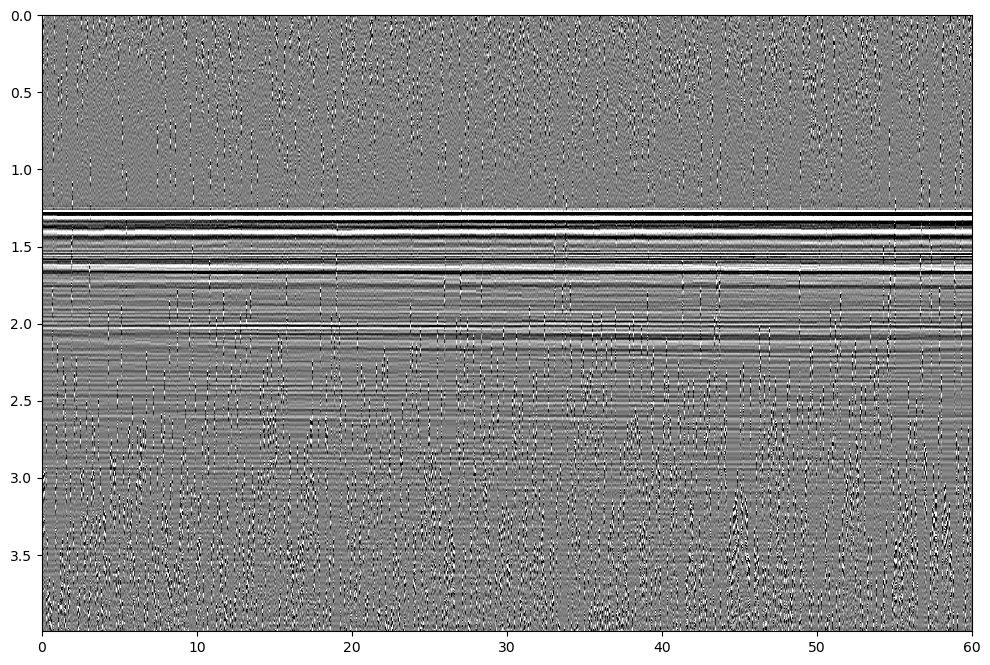

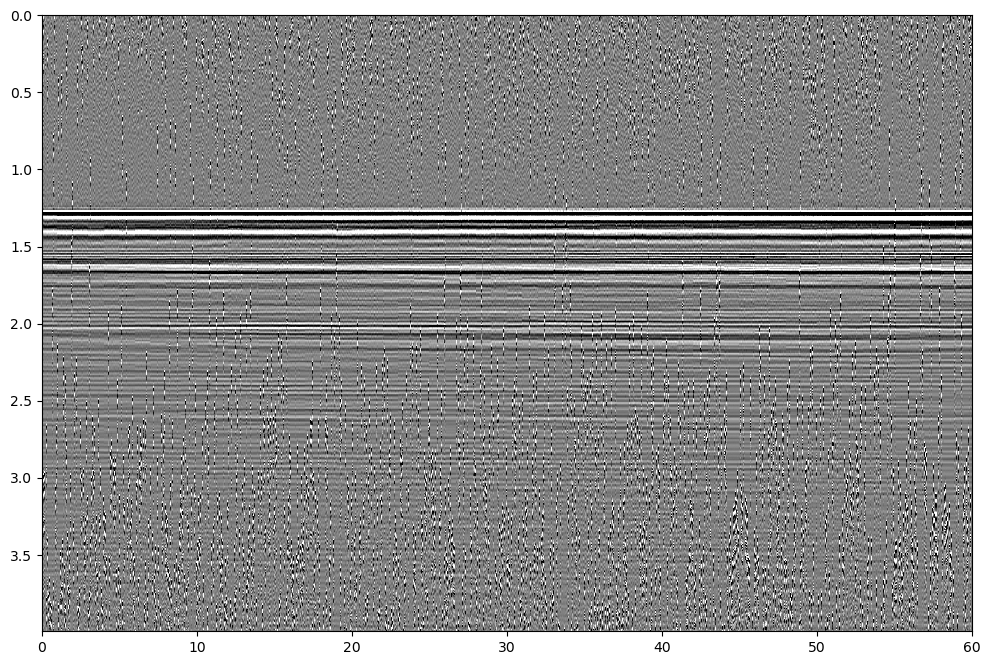

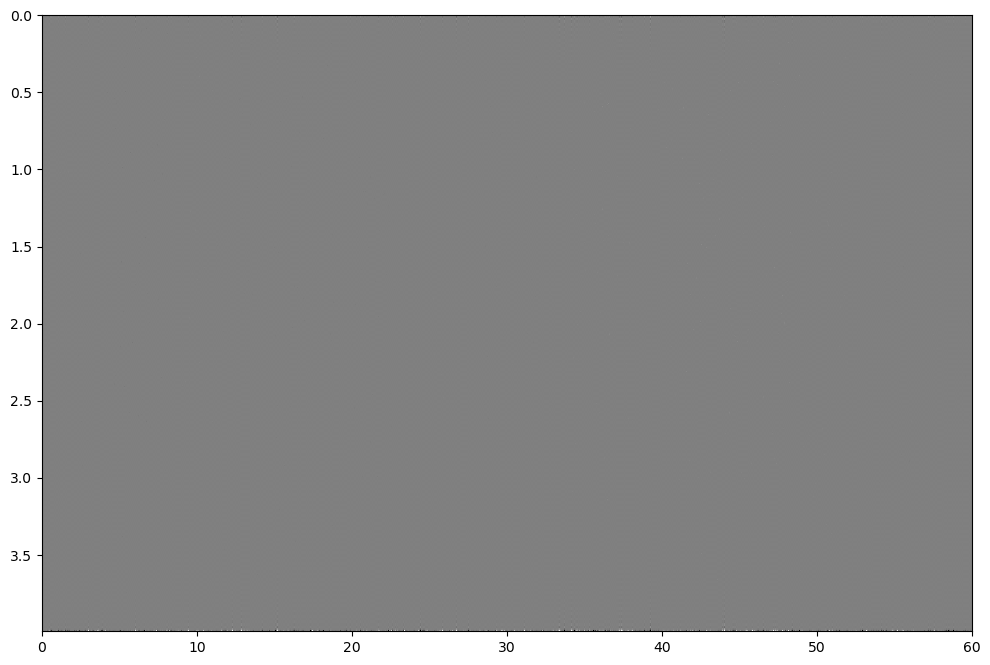

In [36]:
data_blended = Bop * data3d
data_pseudo = Bop.H * data_blended

data_blended1 = Bop1(data3d.transpose(1, 0, 2))
data_pseudo1 = Bop1.adjoint(data_blended1)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo[:, 0].squeeze().T,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.axis("tight")

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo1[0].squeeze().T,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.axis("tight")

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo[:, 0].squeeze().T - data_pseudo1[0].squeeze().T,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.axis("tight");

In [37]:
data3d_cp = cp.asarray(data3d.ravel().astype("float32"))
data_blended_cp = Bopcp.matvec(data3d_cp)
data_pseudo_cp = Bopcp.rmatvec(data_blended_cp)

print(type(data_blended_cp), data_blended_cp.dtype, type(data_pseudo_cp), data_pseudo_cp.dtype)

<class 'cupy.ndarray'> float32 <class 'cupy.ndarray'> float32


In [38]:
%timeit -n 2 -r 2 Bop * data3d
%timeit -n 2 -r 2 Bop1(data3d.transpose(1, 0, 2))
%timeit -n 2 -r 2 Bopcp.matvec(cp.asarray(data3d_cp))

%timeit -n 2 -r 2 Bop.H * data_blended
%timeit -n 2 -r 2 Bop1.adjoint(data_blended1).transpose(1, 0, 2)
%timeit -n 2 -r 2 Bopcp.rmatvec(data_blended_cp)

1.52 s ± 20.5 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
1.66 s ± 2.07 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
693 ms ± 12.6 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
1.69 s ± 8.41 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
1.64 s ± 5.93 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
1.01 s ± 2.2 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


#### Conclusions

When we have many sources and many receivers, our method seems faster **(and GPU even more)**